In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [15]:
N = 100
L = 1000
T = 20

In [16]:
np.empty?

Docstring:
empty(shape, dtype=float, order='C', *, device=None, like=None)

Return a new array of given shape and type, without initializing entries.

Parameters
----------
shape : int or tuple of int
    Shape of the empty array, e.g., ``(2, 3)`` or ``2``.
dtype : data-type, optional
    Desired output data-type for the array, e.g, `numpy.int8`. Default is
    `numpy.float64`.
order : {'C', 'F'}, optional, default: 'C'
    Whether to store multi-dimensional data in row-major
    (C-style) or column-major (Fortran-style) order in
    memory.
device : str, optional
    The device on which to place the created array. Default: ``None``.
    For Array-API interoperability only, so must be ``"cpu"`` if passed.

    .. versionadded:: 2.0.0
like : array_like, optional
    Reference object to allow the creation of arrays which are not
    NumPy arrays. If an array-like passed in as ``like`` supports
    the ``__array_function__`` protocol, the result will be defined
    by it. In this case, it

In [17]:
x = np.empty((N, L), np.float32)
x

array([[-7.2564359e+17,  7.4268819e-43, -5.7037386e+17, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 3.8115318e-43,  2.2841165e-43,            nan, ...,
         2.4802983e-43,  3.5873241e-43,  8.0356059e-41],
       [ 3.4752202e-43,  2.4943113e-43,  3.5873241e-43, ...,
        -3.5436668e-13, -3.6029527e+16, -1.9669535e-11],
       [ 9.1456702e-37, -1.3314494e-32,  2.3694284e-38, ...,
                   nan,            nan, -3.0516536e-05]],
      shape=(100, 1000), dtype=float32)

In [21]:
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N, 1)
x

array([[  27.,   28.,   29., ..., 1024., 1025., 1026.],
       [ -22.,  -21.,  -20., ...,  975.,  976.,  977.],
       [ -31.,  -30.,  -29., ...,  966.,  967.,  968.],
       ...,
       [  34.,   35.,   36., ..., 1031., 1032., 1033.],
       [  41.,   42.,   43., ..., 1038., 1039., 1040.],
       [  41.,   42.,   43., ..., 1038., 1039., 1040.]],
      shape=(100, 1000), dtype=float32)

In [23]:
y = np.sin(x/1.0/T).astype(np.float32)
y

array([[ 0.9757234 ,  0.98544973,  0.992713  , ...,  0.80431294,
         0.83300525,  0.85961556],
       [-0.89120734, -0.86742324, -0.841471  , ..., -0.9984706 ,
        -0.9944597 , -0.98796326],
       [-0.99978375, -0.997495  , -0.992713  , ..., -0.923117  ,
        -0.94118106, -0.9568938 ],
       ...,
       [ 0.9916648 ,  0.98398596,  0.9738476 , ...,  0.9593011 ,
         0.9722154 ,  0.9827005 ],
       [ 0.8873624 ,  0.8632094 ,  0.83689874, ...,  0.9979704 ,
         0.99354064,  0.9866276 ],
       [ 0.8873624 ,  0.8632094 ,  0.83689874, ...,  0.9979704 ,
         0.99354064,  0.9866276 ]], shape=(100, 1000), dtype=float32)

C:\Users\zelaw\AppData\Local\Temp\ipykernel_12252\83319599.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


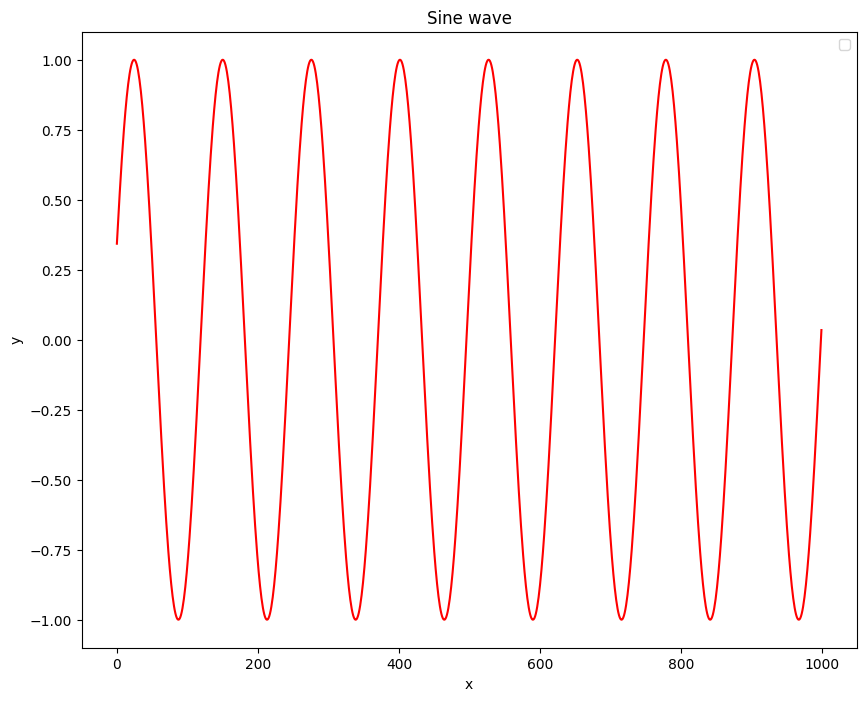

In [20]:
plt.figure(figsize=(10, 8))
plt.title("Sine wave")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(np.arange(x.shape[1]), y[0, :], 'r')
plt.legend()
plt.show()

In [24]:
class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.lstm1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)

    def forward(self, x, future=0):
        # N, 100
        outputs = []
        n_samples = x.size(0)

        h_t = torch.zeros(n_samples, self.n_hidden, dtype=x.dtype)
        c_t = torch.zeros(n_samples, self.n_hidden, dtype=x.dtype)
        h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=x.dtype)
        c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=x.dtype)

        for input_t in x.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        outputs = torch.cat(outputs, dim=1)
        return outputs       

In [25]:
train_input = torch.from_numpy(y[3:, :-1])
train_target = torch.from_numpy(y[3:, 1:])
test_input = torch.from_numpy(y[:3, :-1])
test_target = torch.from_numpy(y[:3, 1:])

In [26]:
model = LSTMPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.8)

Step 1
Loss: 0.5290381908416748
Loss: 0.5165584683418274
Loss: 0.4956991374492645
Loss: 0.48800426721572876
Loss: 0.46655547618865967
Loss: 0.3642069399356842
Loss: 0.16638211905956268
Loss: 0.05083569884300232
Loss: 0.06236708536744118
Loss: 0.029155902564525604
Loss: 0.0241111908107996
Loss: 0.02352313883602619
Loss: 0.02119261957705021
Loss: 0.017460474744439125
Loss: 0.012995746918022633
Loss: 0.006902308203279972
Loss: 0.004668418783694506
Loss: 0.003897350514307618
Loss: 0.0024008217733353376
Loss: 0.0019921346101909876
Test loss: 0.0018921566661447287


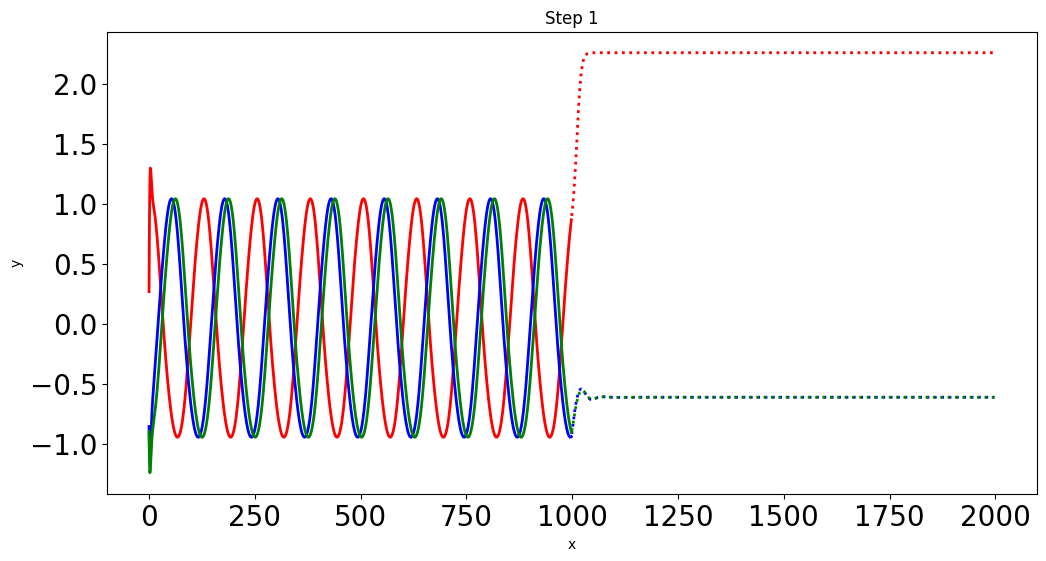

Step 2
Loss: 0.0018145074136555195
Loss: 0.0017292015254497528
Loss: 0.001466721179895103
Loss: 0.0010366766946390271
Loss: 0.0007240975392051041
Loss: 0.0006227486883290112
Loss: 0.0006089075468480587
Loss: 0.000605899840593338
Loss: 0.0006020379369147122
Loss: 0.0005930522456765175
Loss: 0.0005734801525250077
Loss: 0.0005347288679331541
Loss: 0.0004748305073007941
Loss: 0.000396961608203128
Loss: 0.00032520401873625815
Loss: 0.00028029619716107845
Loss: 0.00025630692834965885
Loss: 0.0002488666505087167
Loss: 0.0002439470263198018
Loss: 0.00024093882529996336
Test loss: 0.0003028580395039171


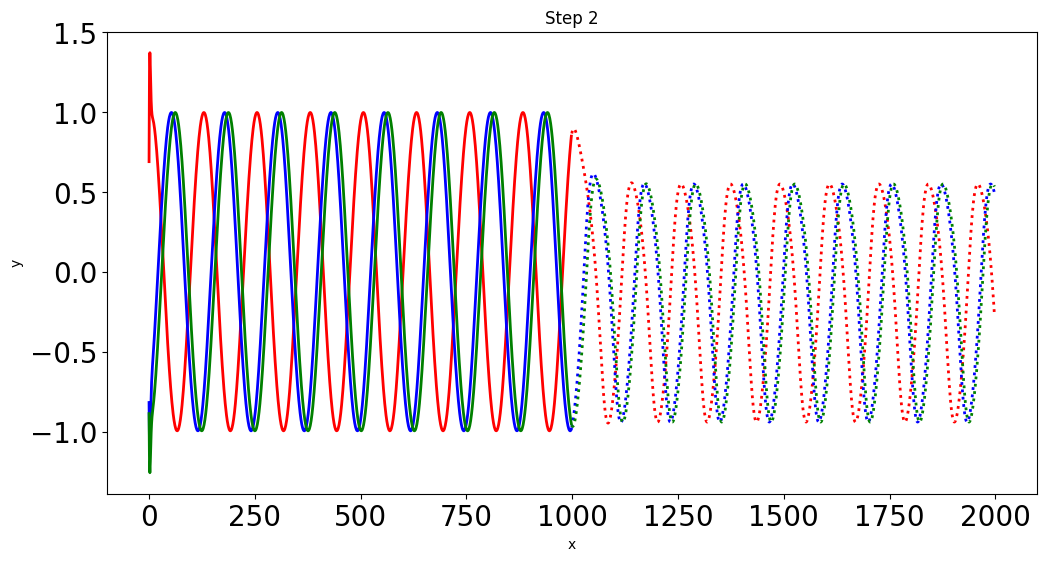

Step 3
Loss: 0.00023912858159746975
Loss: 0.000238275300944224
Loss: 0.00023762340424582362
Loss: 0.00023610721109434962
Loss: 0.00023298875021282583
Loss: 0.00022910968982614577
Loss: 0.00022280297707766294
Loss: 0.00021215551532804966
Loss: 0.00020087440498173237
Loss: 0.00018700704094953835
Loss: 0.0001768737711245194
Loss: 0.00016694801161065698
Loss: 0.00016365105693694204
Loss: 0.00016293716907966882
Loss: 0.00016251567285507917
Loss: 0.00016194155614357442
Loss: 0.00016147125279530883
Loss: 0.00016078128828667104
Loss: 0.00015618102042935789
Loss: 0.0001342947070952505
Test loss: 0.00020716052677016705


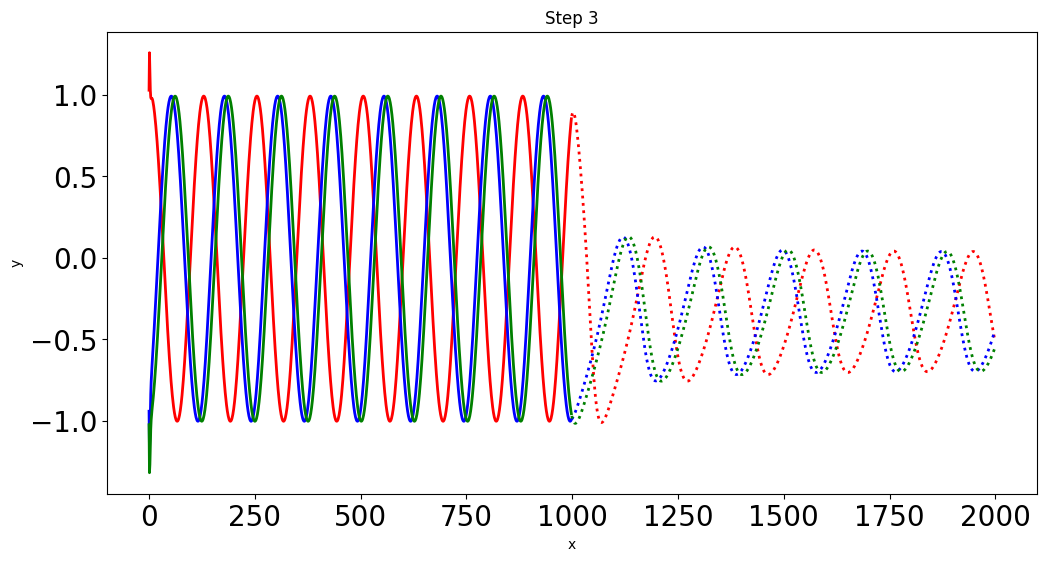

Step 4
Loss: 0.000120815537229646
Loss: 0.00010230899351881817
Loss: 8.354515739483759e-05
Loss: 7.300410652533174e-05
Loss: 7.938539056340232e-05
Loss: 6.834715895820409e-05
Loss: 6.745303107891232e-05
Loss: 6.638439663220197e-05
Loss: 6.507043144665658e-05
Loss: 6.399904668796808e-05
Loss: 6.2764243921265e-05
Loss: 6.262454553507268e-05
Loss: 6.245614349609241e-05
Loss: 6.224069511517882e-05
Loss: 6.181113712955266e-05
Loss: 6.09488197369501e-05
Loss: 5.920158946537413e-05
Loss: 5.6685290473978966e-05
Loss: 5.476532896864228e-05
Loss: 6.996347656240687e-05
Test loss: 8.27431067591533e-05


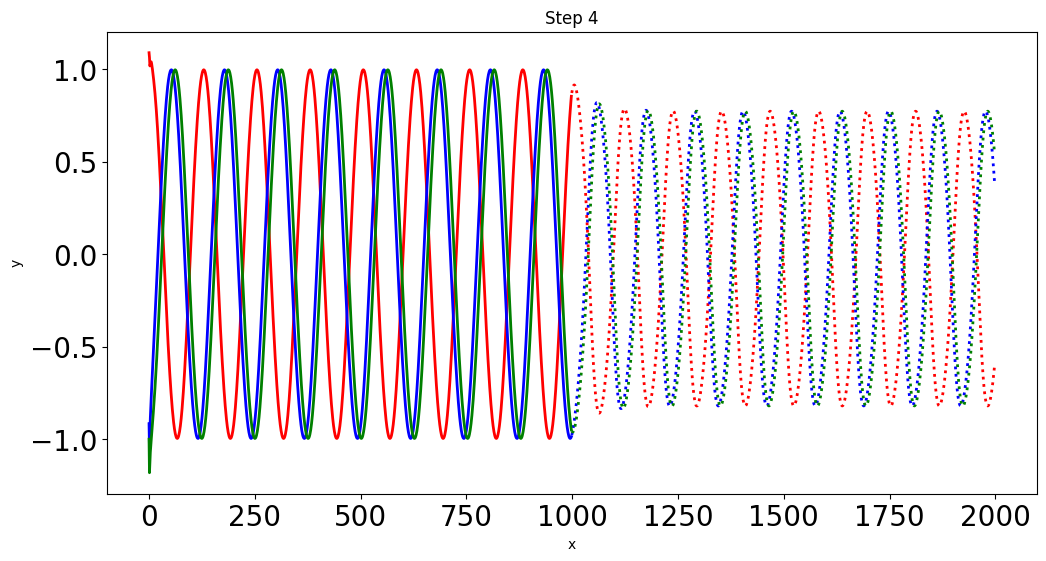

Step 5
Loss: 5.1943752623628825e-05
Loss: 5.1340506615815684e-05
Loss: 5.078852336737327e-05
Loss: 5.0282342272112146e-05
Loss: 4.9299786041956395e-05
Loss: 4.811550388694741e-05
Loss: 4.7558856749674305e-05
Loss: 4.74479966214858e-05
Loss: 4.73672516818624e-05
Loss: 4.73281615995802e-05
Loss: 4.69524493382778e-05
Loss: 4.6584180381614715e-05
Loss: 4.5701257477048784e-05
Loss: 4.384752901387401e-05
Loss: 4.0887891373131424e-05
Loss: 4.597201041178778e-05
Loss: 3.877710332744755e-05
Loss: 3.829075285466388e-05
Loss: 3.752511111088097e-05
Loss: 3.61197890015319e-05
Test loss: 5.0012837164103985e-05


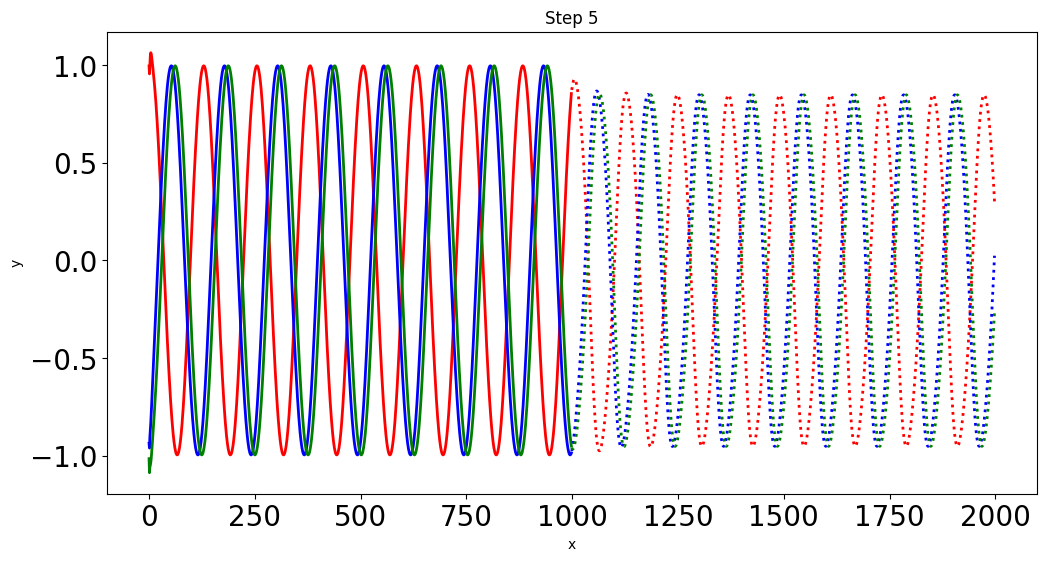

Step 6
Loss: 3.474629556876607e-05
Loss: 3.344910146552138e-05
Loss: 3.249412475270219e-05
Loss: 3.225591353839263e-05
Loss: 3.1838433642406017e-05
Loss: 3.1497238524025306e-05
Loss: 3.127664604107849e-05
Loss: 3.1168139685178176e-05
Loss: 3.0691808206029236e-05
Loss: 2.694197064556647e-05
Loss: 2.4357244910788722e-05
Loss: 3.71033966075629e-05
Loss: 2.2461275875684805e-05
Loss: 2.1803098206873983e-05
Loss: 2.121175748470705e-05
Loss: 1.9601244275690988e-05
Loss: 1.9004664864041843e-05
Loss: 1.826580955821555e-05
Loss: 1.7905167624121532e-05
Loss: 1.767053072398994e-05
Test loss: 2.3223852622322738e-05


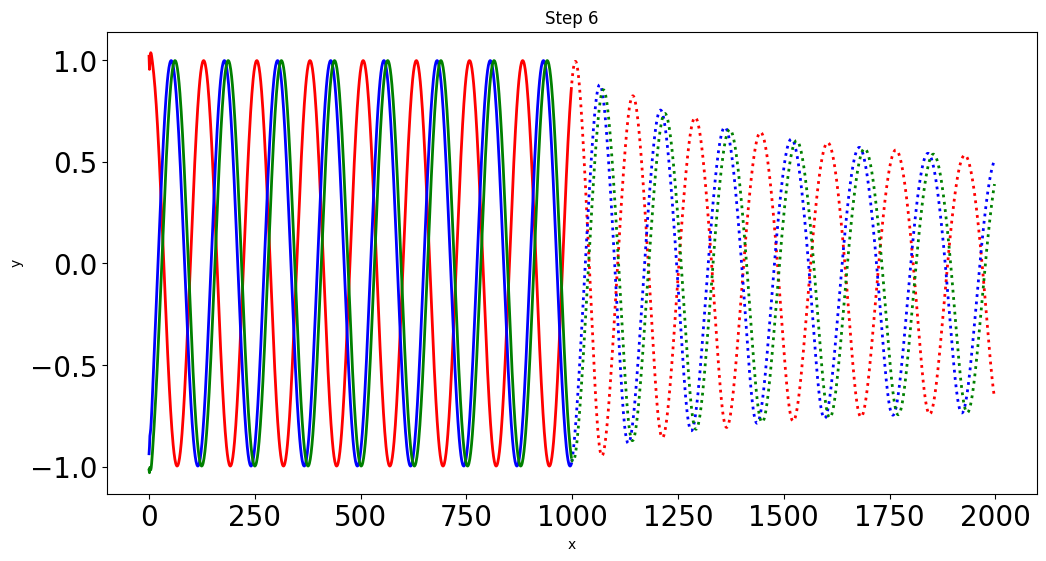

Step 7
Loss: 1.7308768292423338e-05
Loss: 1.6897378372959793e-05
Loss: 1.6468549802084453e-05
Loss: 1.578853880346287e-05
Loss: 1.541447636554949e-05
Loss: 1.5147364138101693e-05
Loss: 1.4826860024186317e-05
Loss: 1.4462121725955512e-05
Loss: 1.4268503946368583e-05
Loss: 1.4217780517356005e-05
Loss: 1.4160519640427083e-05
Loss: 1.3832624063070398e-05
Loss: 1.2539405361167155e-05
Loss: 1.214725762110902e-05
Loss: 1.1945473488594871e-05
Loss: 1.191443152492866e-05
Loss: 1.1913179150724318e-05
Loss: 1.1866259228554554e-05
Loss: 1.1818818165920675e-05
Loss: 1.1758926120819524e-05
Test loss: 1.522795355413109e-05


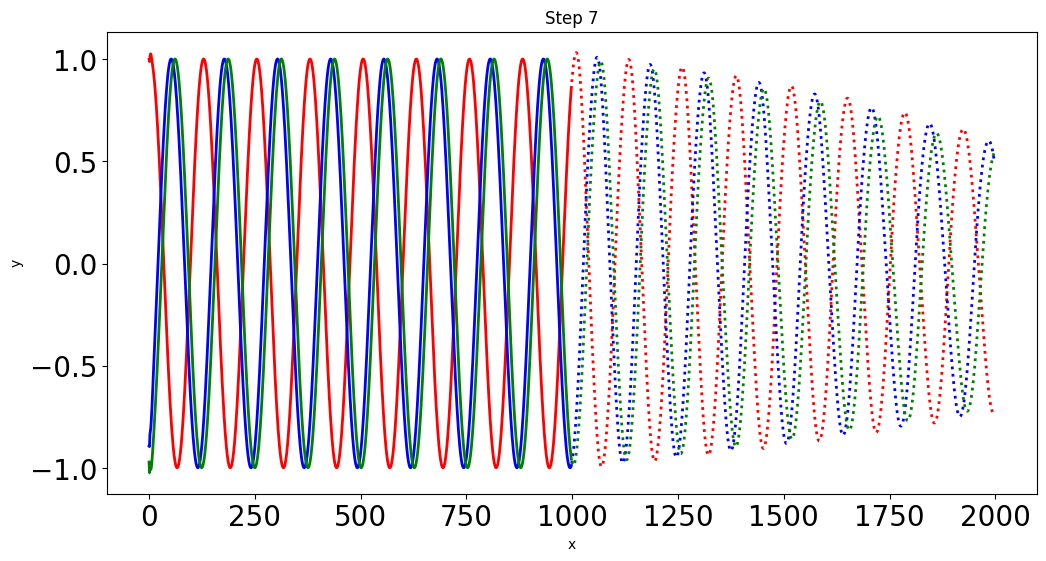

Step 8
Loss: 1.1690366591210477e-05
Loss: 1.1627916137513239e-05
Loss: 1.159623934654519e-05
Loss: 1.1578466910577845e-05
Loss: 1.1559497579582967e-05
Loss: 1.1542824722710066e-05
Loss: 1.1531450581969693e-05
Loss: 1.1512372111610603e-05
Loss: 1.1412783351261169e-05
Loss: 1.1330200322845485e-05
Loss: 1.1192931197001599e-05
Loss: 1.1045909559470601e-05
Loss: 1.0913719052041415e-05
Loss: 1.0802286851685494e-05
Loss: 1.0727549124567304e-05
Loss: 1.0694360753404908e-05
Loss: 1.067563789547421e-05
Loss: 1.0663155990187079e-05
Loss: 1.0656537597242277e-05
Loss: 1.0653164281393401e-05
Test loss: 1.6308191334246658e-05


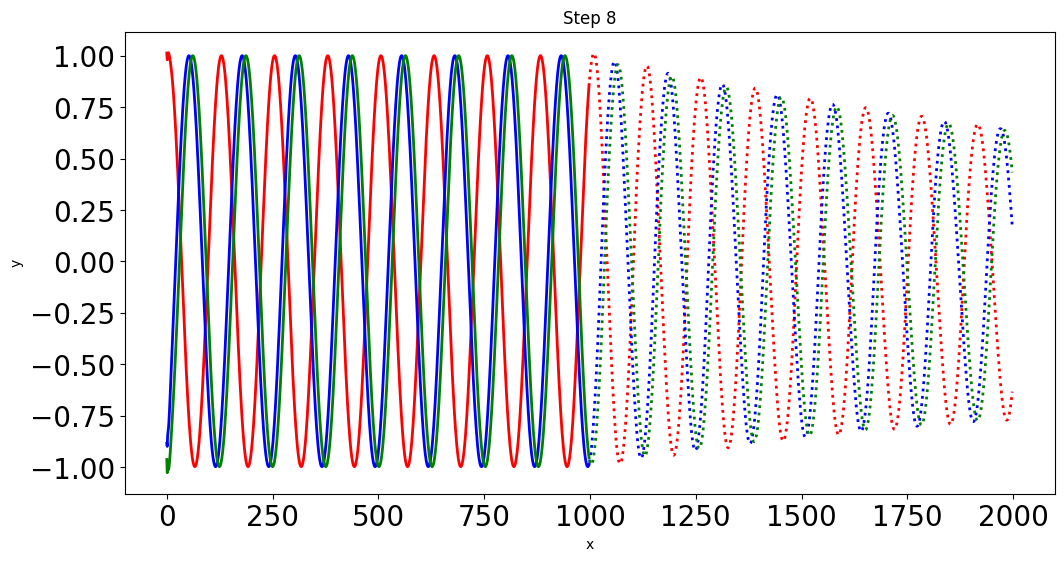

Step 9
Loss: 1.0648932402546052e-05
Loss: 1.0636679689923767e-05
Loss: 1.0604589078866411e-05
Loss: 1.0533713066251948e-05
Loss: 1.03589127320447e-05
Loss: 9.992046216211747e-06
Loss: 9.48409979173448e-06
Loss: 3.798988109338097e-05
Loss: 8.557407454645727e-06
Loss: 8.01542500994401e-06
Loss: 8.88169051904697e-06
Loss: 7.384540367638692e-06
Loss: 7.251467195601435e-06
Loss: 7.1249305619858205e-06
Loss: 6.998784556344617e-06
Loss: 6.927496087882901e-06
Loss: 6.908781415404519e-06
Loss: 6.904038855282124e-06
Loss: 6.901401320646983e-06
Loss: 6.898425453982782e-06
Test loss: 6.736614068358904e-06


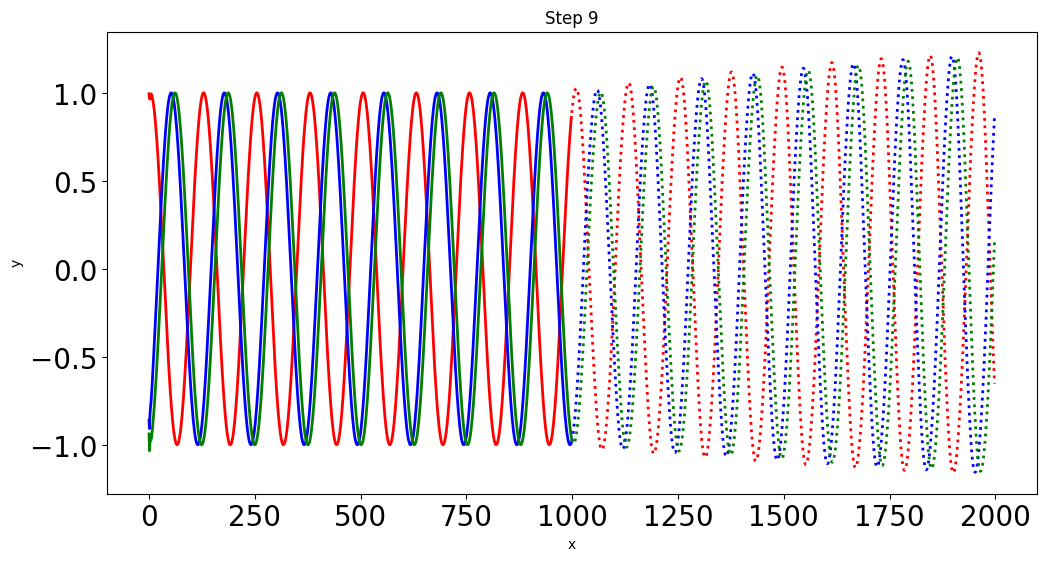

Step 10
Loss: 6.89339731252403e-06
Loss: 6.884295544296037e-06
Loss: 6.869618573546177e-06
Loss: 6.857044354546815e-06
Loss: 6.848332759545883e-06
Loss: 6.8394797381188255e-06
Loss: 6.831732662249124e-06
Loss: 6.819040208938532e-06
Loss: 6.801350991736399e-06
Loss: 6.7745536398433615e-06
Loss: 6.7601145019580144e-06
Loss: 6.752265107934363e-06
Loss: 6.747520274075214e-06
Loss: 6.741902780049713e-06
Loss: 6.73313934385078e-06
Loss: 6.716052212141221e-06
Loss: 6.699094683426665e-06
Loss: 6.675977147097001e-06
Loss: 6.910207048349548e-06
Loss: 6.651729563600384e-06
Test loss: 5.554398285312345e-06


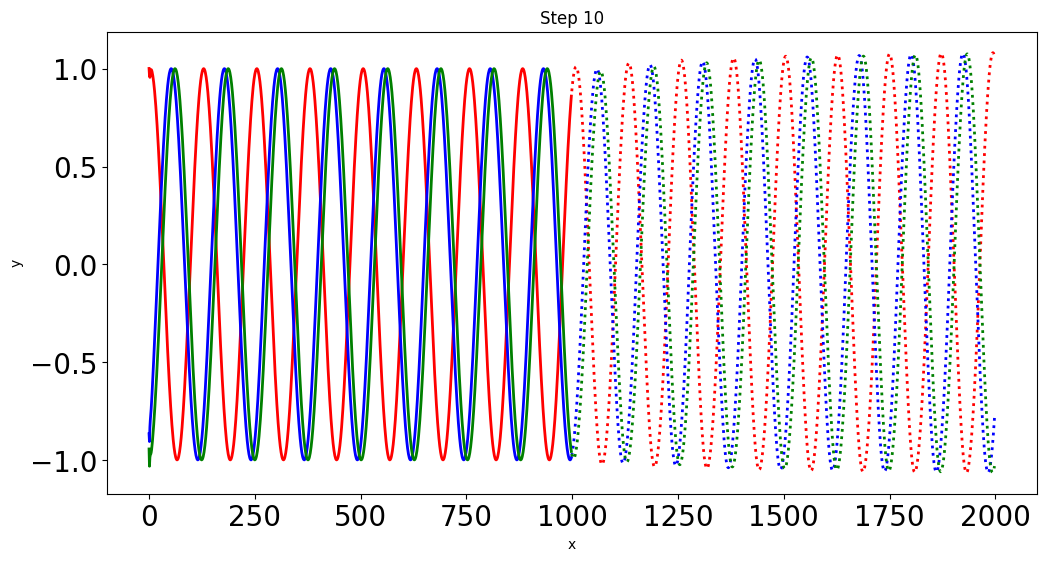

In [27]:
n_steps = 10

for i in range(n_steps):
    print(f"Step {i+1}")

    def closure():
        optimizer.zero_grad()
        out = model(train_input)
        loss = criterion(out, train_target)
        loss.backward()
        print(f"Loss: {loss.item()}")
        return loss
    
    optimizer.step(closure)

    with torch.no_grad():
        future=1000
        pred = model(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print(f"Test loss: {loss.item()}")
        y = pred.detach().numpy()
    
    plt.figure(figsize=(12, 6))
    plt.title("Step " + str(i+1))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    n = train_input.shape[1]
    
    def draw(yi, color):
        plt.plot(np.arange(n), yi[:n], color, linewidth=2.0)
        plt.plot(np.arange(n, n+future), yi[n:], color + ':', linewidth=2.0)
    
    draw(y[0], 'r')
    draw(y[1], 'b')
    draw(y[2], 'g')

    plt.show()